In [5]:
import taichi as ti
import numpy as np
import sys
sys.path.insert(0, 'D:\Research\diffmpm_bridge\engine')


import utils as utils
import matplotlib.pyplot as plt

ti.reset()
real = ti.f32
ti.init(arch=ti.cuda, default_fp=real, device_memory_GB=12)

# init parameters
size = 1
dim = 2
N = 2
n_particles = N*N
n_grid = 10
dx = 1 / n_grid
inv_dx = 1 / dx
dt = 1e-3
p_mass = 1
p_vol = 1
E = ti.field(dtype=real, shape=(), needs_grad=True)
nu = 0
mu = ti.field(dtype=real, shape=(), needs_grad=True)
la = ti.field(dtype=real, shape=(), needs_grad=True)
E[None] = 1000000.0
max_steps = 1000
steps = max_steps
gravity = 0

x = ti.Vector.field(dim,
                    dtype=real,
                    shape=(max_steps, n_particles),
                    needs_grad=True)
v = ti.Vector.field(dim,
                    dtype=real,
                    shape=(max_steps, n_particles),
                    needs_grad=True)
grid_v_in = ti.Vector.field(dim,
                            dtype=real,
                            shape=(max_steps, n_grid, n_grid),
                            needs_grad=True)
grid_v_out = ti.Vector.field(dim,
                             dtype=real,
                             shape=(max_steps, n_grid, n_grid),
                             needs_grad=True)
f_ext = ti.Vector.field(dim,
                        dtype=real,
                        shape=(max_steps, n_grid, n_grid),
                        needs_grad=True)
grid_m_in = ti.field(dtype=real,
                     shape=(max_steps, n_grid, n_grid),
                     needs_grad=True)
C = ti.Matrix.field(dim,
                    dim,
                    dtype=real,
                    shape=(max_steps, n_particles),
                    needs_grad=True)
F = ti.Matrix.field(dim,
                    dim,
                    dtype=real,
                    shape=(max_steps, n_particles),
                    needs_grad=True)
strain = ti.Matrix.field(dim,
                         dim,
                         dtype=real,
                         shape=(max_steps, n_particles),
                         needs_grad=True)
strain2 = ti.Matrix.field(dim,
                          dim,
                          dtype=real,
                          shape=(max_steps + 1, n_particles),
                          needs_grad=True)
init_v = ti.Vector.field(dim, dtype=real, shape=(), needs_grad=True)
loss = ti.field(dtype=real, shape=(), needs_grad=True)

@ti.kernel
def set_v():
    for i in range(n_particles):
        v[0, i] = init_v[None]

@ti.kernel
def p2g(f: ti.i32):
    for p in range(n_particles):
        base = ti.cast(x[f, p] * inv_dx - 0.5, ti.i32)
        fx = x[f, p] * inv_dx - ti.cast(base, ti.i32)
        w = [0.5 * (1.5 - fx)**2, 0.75 - (fx - 1)**2, 0.5 * (fx - 0.5)**2]
        new_F = (ti.Matrix.diag(dim=2, val=1) + dt * C[f, p]) @ F[f, p]
        F[f + 1, p] = new_F
        J = (new_F).determinant()
        r, s = ti.polar_decompose(new_F)
        cauchy = 2 * E[None] / (2 * (1 + nu)) * (new_F - r) @ new_F.transpose() + \
                 ti.Matrix.diag(2, E[None] * nu / ((1 + nu) * (1 - 2 * nu)) * (J - 1) * J)
        # cauchy = 2 * mu * (new_F - r) @ new_F.transpose() + \
        #          ti.Matrix.diag(2, la * (J - 1) * J)
        stress = -(dt * p_vol * 4 * inv_dx * inv_dx) * cauchy
        print(stress)
        affine = stress + p_mass * C[f, p]
        strain[f, p] += 0.5 * (new_F.transpose() @ new_F - ti.math.eye(dim))
        for i in ti.static(range(3)):
            for j in ti.static(range(3)):
                offset = ti.Vector([i, j])
                dpos = (ti.cast(ti.Vector([i, j]), real) - fx) * dx
                weight = w[i][0] * w[j][1]
                grid_v_in[f, base + offset] += weight * (p_mass * v[f, p] +
                                                         affine @ dpos)
                grid_m_in[f, base + offset] += weight * p_mass
                

                
bound = 1

@ti.kernel
def grid_op(f: ti.i32):
    for i, j in ti.ndrange(n_grid, n_grid):
        inv_m = 1 / (grid_m_in[f, i, j] + 1e-10)
        v_out = inv_m * grid_v_in[f, i, j] + dt * f_ext[f, i, j]
        v_out[1] -= dt * gravity
        # if i < bound and v_out[0] < 0:
        #     v_out[0] = 0
        # if i > n_grid - bound and v_out[0] > 0:
        #     v_out[0] = 0
        # if j < bound and v_out[1] < 0:
        #     v_out[1] = 0
        # if j > n_grid - bound and v_out[1] > 0:
        #     v_out[1] = 0
        grid_v_out[f, i, j] = v_out


@ti.kernel
def g2p(f: ti.i32):
    # ti.loop_config(serialize=True)
    for p in range(n_particles):
        base = ti.cast(x[f, p] * inv_dx - 0.5, ti.i32)
        fx = x[f, p] * inv_dx - ti.cast(base, real)
        w = [0.5 * (1.5 - fx)**2, 0.75 - (fx - 1.0)**2, 0.5 * (fx - 0.5)**2]
        new_v = ti.Vector([0.0, 0.0])
        new_C = ti.Matrix([[0.0, 0.0], [0.0, 0.0]])

        for i in ti.static(range(3)):
            for j in ti.static(range(3)):
                dpos = ti.cast(ti.Vector([i, j]), real) - fx
                g_v = grid_v_out[f, base[0] + i, base[1] + j]
                weight = w[i][0] * w[j][1]
                new_v += weight * g_v
                new_C += 4 * weight * g_v.outer_product(dpos) * inv_dx
        
        # shapefn = ti.Vector([0.0, 0.0, 0.0, 0.0])
        grad = ti.Matrix([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
        vi = ti.Matrix([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
        dstrain = ti.Matrix([[0.0, 0.0], [0.0, 0.0]])

        grad[0, 0] = -0.25 * (1 - fx[1])
        grad[1, 0] = 0.25 * (1 - fx[1])
        grad[2, 0] = 0.25 * (1 + fx[1])
        grad[3, 0] = -0.25 * (1 + fx[1])

        grad[0, 1] = -0.25 * (1 - fx[0])
        grad[1, 1] = -0.25 * (1 + fx[0])
        grad[2, 1] = 0.25 * (1 + fx[0])
        grad[3, 1] = 0.25 * (1 - fx[0])

        vi[0, 0] = grid_v_out[f, base[0], base[1]][0]
        vi[1, 0] = grid_v_out[f, base[0] + 1, base[1]][0]
        vi[2, 0] = grid_v_out[f, base[0] + 1, base[1] + 1][0]
        vi[3, 0] = grid_v_out[f, base[0], base[1] + 1][0]

        vi[0, 1] = grid_v_out[f, base[0], base[1]][1]
        vi[1, 1] = grid_v_out[f, base[0] + 1, base[1]][1]
        vi[2, 1] = grid_v_out[f, base[0] + 1, base[1] + 1][1]
        vi[3, 1] = grid_v_out[f, base[0], base[1] + 1][1]
        
        for i in ti.static(range(2)):
            for j in ti.static(range(2)):
                for k in ti.static(range(4)):
                    dstrain[i, j] += 0.5 * (grad[k, i] * vi[k, j] + grad[k, j] * vi[k, i])
   
        strain2[f + 1, p] = strain2[f, p] + dstrain * dt

        v[f + 1, p] = new_v
        x[f + 1, p] = x[f, p] + dt * v[f + 1, p]
        C[f + 1, p] = new_C

@ti.kernel
def compute_loss():
    for i in range(steps - 1):
        for j in range(n_particles):
            dist = (1 / ((steps - 1) * n_particles)) * \
                (target_x[i, j] - x[i, j]) ** 2
            loss[None] += 0.5 * (dist[0] + dist[1])
            # dist = (1 / ((steps - 1) * n_particles)) * \
            #     (target_strain[i, j] - strain[i, j]) ** 2
            # loss[None] += 0.5 * (dist[0, 0] + dist[1, 1])


def substep(s):
    p2g(s)
    # grid_op(s)
    g2p(s)


@ti.kernel
def assign_ext_load():
    # for t in range(max_steps):
    #     for node in node_ids_fext_x:
    #         f_ext[t, node, node] = [0, f_ext_scale * e[t, node]]
    for t in range(max_steps):
        for i in range(n_grid):
            for j in range(n_grid):
                f_ext[t, 9, j] = [0, -1e2]
                f_ext[t, 17, j] = [0, 1e2]


f_ext_scale = 1   
velocity = 4
frequency = 5
node_x_locs = np.arange(0, 1, 1 / n_grid)
time_to_center = node_x_locs / velocity
t_steps = np.arange(max_steps) * dt
t_steps_n = np.array([t_steps - time for time in time_to_center])
t_steps_n = np.stack(t_steps_n, axis=1)
node_ids_fext_x = range(n_grid)
_, _, e, = utils.gausspulse(t_steps_n)
print('assigning external loads')
assign_ext_load()

init_v[None] = [0, 0]


for i in range(n_particles):
    F[0, i] = [[1, 0], [0, 1]]



for i in range(N):
    for j in range(N):
        x[0, i * N + j] = [(i)/(4*N) + 0.2, (j)/(4*N) + 0.2]
    






print('running target sim')
# reset_sim()
set_v()
# set_E()

for s in range(steps):
    substep(s)





[Taichi] Starting on arch=cuda
assigning external loads
running target sim


: 

In [19]:
np.load('stresses2.npy').shape

(1001, 12, 2, 2)

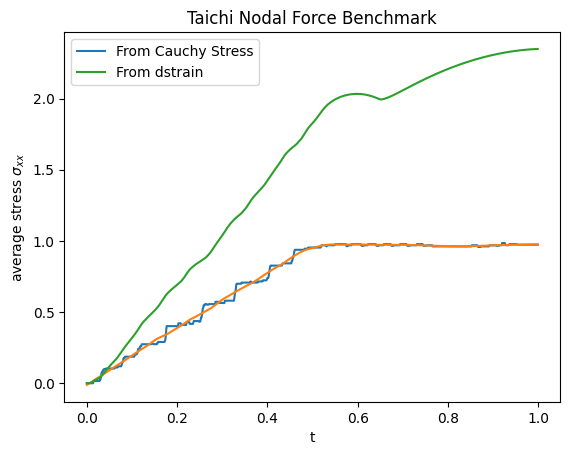

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

stresses = np.load('stresses.npy')[:-1, :, 0]
stresses2 = np.load('stresses2.npy')[:-1, :, 0]

plt.plot(np.arange(len(stresses)) * 1e-3, np.mean(stresses, axis=1), label='From Cauchy Stress')
plt.plot(np.arange(len(stresses)) * 1e-3, savgol_filter(np.mean(stresses, axis=1), 200, 2))
plt.plot(np.arange(len(stresses)) * 1e-3, np.mean(stresses2, axis=1), label='From dstrain')
plt.xlabel('t')
plt.ylabel('average stress $\sigma_{xx}$')
plt.title('Taichi Nodal Force Benchmark')
plt.legend()
plt.show()

